# Initalizing wandb, importing data, and normalizing

In [6]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from neuralop.models import FNO
import scipy.io
import wandb
import urllib.request
import os

# Change this to the actual path on your computer for FDTD data.
DATA_PATH = r'E:\FDTD_FNO_Project\Generated Data\FDTD_data_2.mat'  # Example: 'C:/Users/brobl/Downloads/burgers_data_R10.mat'

# Initialize wandb
wandb.init(
    project="fdtd-fno",
    config={
        "n_modes": 100,
        "hidden_channels": 128,
        "n_layers": 4,
        "learning_rate": 0.001,
        "epochs": 500,
        "batch_size": 20,
        "train_resolution": 2300,
        "test_resolution": 2300
    }
)

config = wandb.config

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")
wandb.config.update({"device": str(device)})

# Load the data
print(f"Loading FDTD data from: {DATA_PATH}")
data = scipy.io.loadmat(DATA_PATH)

# Split train/test
n_train = 150
n_test = 50

# Extract data
# Data format: a contains initial conditions, u contains solutions

print("Available keys in data:", data.keys())
a = np.transpose(data['training_data'], (1, 0, 2))  # Initial conditions after source propogation
u =  np.transpose(data['test_data'], (1, 0, 2)) # Solutions

# Checking shapes for troubleshooting
print(f"Initial conditions shape: {a.shape}")
print(f"Solutions shape: {u.shape}")
print(f"Initial conditions dtype: {a.dtype}")
print(f"Solutions dtype: {u.dtype}")


train_inputs = a[:n_train]
train_outputs = u[:n_train]

# NORMALIZATION
# Combine input and output 
# This ensures Ex at t=0 and Ex at t=T use the same normalization
combined_data = np.concatenate([train_inputs, train_outputs], axis=0)  # (2*n_train, 3, length)

# Define channels and their data sources
channel_names = ['ex', 'hz', 'eps']
sources = [combined_data, combined_data, train_inputs]  # eps uses input only

# Initialize
norm_stats = {}
a_normalized = a.copy()
u_normalized = u.copy()

# Compute normalization stats and apply
for i, (name, source) in enumerate(zip(channel_names, sources)):
    mean = source[:, i, :].mean()
    std = source[:, i, :].std()

    norm_stats[f'{name}_mean'] = mean
    norm_stats[f'{name}_std'] = std

    a_normalized[:, i, :] = (a[:, i, :] - mean) / (std + 1e-8)
    u_normalized[:, i, :] = (u[:, i, :] - mean) / (std + 1e-8)

    print(f"{name.upper()} normalization - Mean: {mean:.6f}, Std: {std:.6f}")

# Convert to torch tensors
x_train = torch.FloatTensor(a_normalized[:n_train]).to(device)  # (n_train, 3, s)
y_train = torch.FloatTensor(u_normalized[:n_train]).to(device)
x_test = torch.FloatTensor(a_normalized[-n_test:]).to(device)
y_test = torch.FloatTensor(u_normalized[-n_test:]).to(device)

print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")



KeyboardInterrupt: 

# Check Data Samples


Visualizing training data samples...


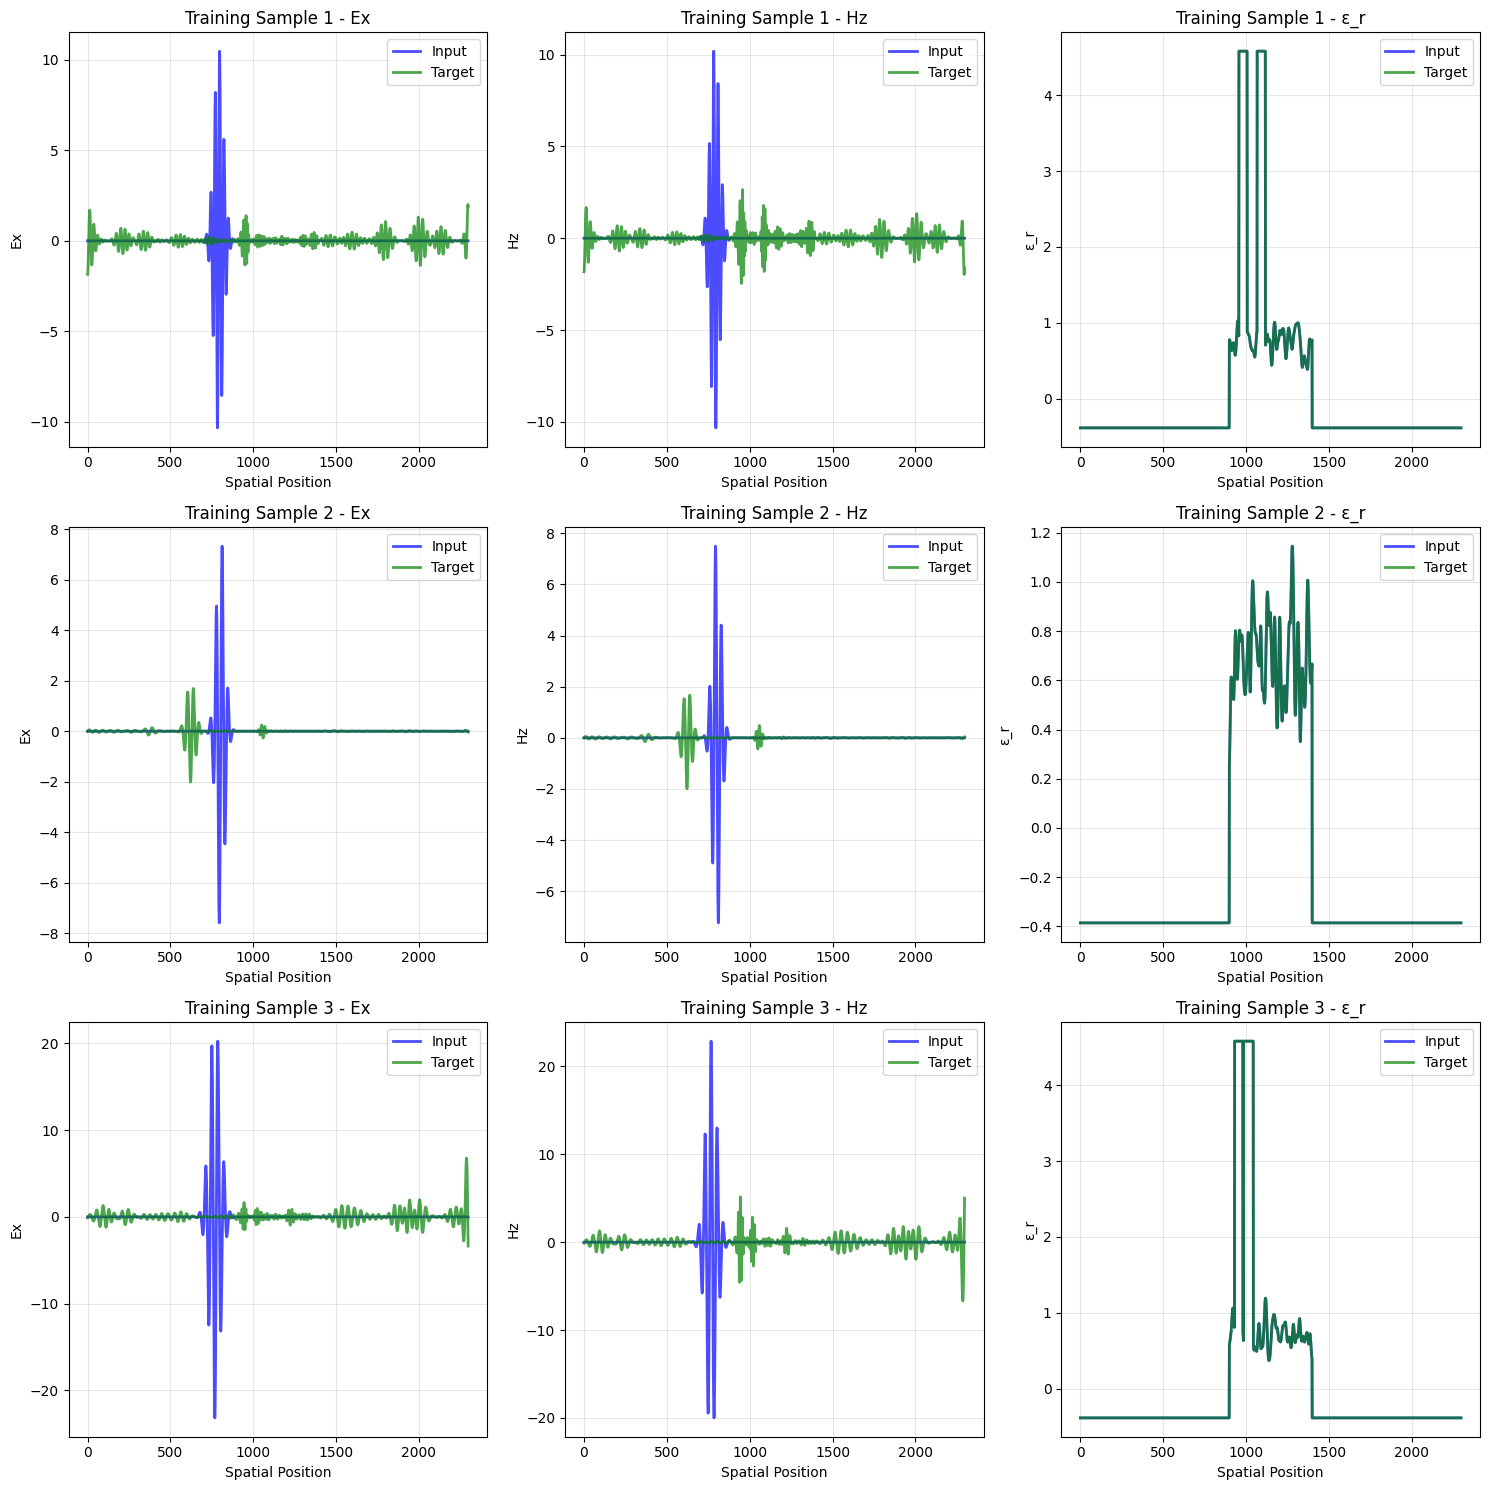

In [ ]:
# Visualize some training data samples
print("\nVisualizing training data samples...")
n_samples = min(3, len(x_train))
fig, axes = plt.subplots(n_samples, 3, figsize=(15, 5*n_samples))
if n_samples == 1:
    axes = axes.reshape(1, -1)

channel_names = ['Ex', 'Hz', 'ε_r']
x_coords = np.arange(x_train.shape[2])

for sample_idx in range(n_samples):
    for ch_idx, ch_name in enumerate(channel_names):
        # Plot input
        axes[sample_idx, ch_idx].plot(x_coords, x_train[sample_idx, ch_idx].cpu().numpy(), 
                                      'b-', label='Input', linewidth=2, alpha=0.7)
        # Plot target
        axes[sample_idx, ch_idx].plot(x_coords, y_train[sample_idx, ch_idx].cpu().numpy(), 
                                      'g-', label='Target', linewidth=2, alpha=0.7)
        axes[sample_idx, ch_idx].set_xlabel('Spatial Position')
        axes[sample_idx, ch_idx].set_ylabel(ch_name)
        axes[sample_idx, ch_idx].set_title(f'Training Sample {sample_idx+1} - {ch_name}')
        axes[sample_idx, ch_idx].legend()
        axes[sample_idx, ch_idx].grid(True, alpha=0.3)

plt.tight_layout()

# Save figure locally first
fig.savefig('data_samples.png', dpi=150, bbox_inches='tight')

# Log to wandb using the saved file
wandb.log({"data_samples": wandb.Image('data_samples.png')})
plt.show()
plt.close()

# FNO Model setupand training. Modified from 1D burgers equation sample. Currently predicts eps_r will change that though


Model parameters: 3,543,171

Starting training...


c:\Users\brobl\AppData\Local\Programs\Python\Python312\Lib\site-packages\wandb\integration\torch\wandb_torch.py:204: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Copy.cpp:307.)
  flat = flat.type(torch.FloatTensor)


Epoch 20/500 | Train Loss: 0.156484 | Test Loss: 0.156735 | Rel L2: 0.515882
Epoch 40/500 | Train Loss: 0.146998 | Test Loss: 0.147004 | Rel L2: 0.499665
Epoch 60/500 | Train Loss: 0.140100 | Test Loss: 0.139616 | Rel L2: 0.490156
Epoch 80/500 | Train Loss: 0.120835 | Test Loss: 0.119448 | Rel L2: 0.468148
Epoch 100/500 | Train Loss: 0.095098 | Test Loss: 0.094269 | Rel L2: 0.437384
Epoch 120/500 | Train Loss: 0.083431 | Test Loss: 0.082985 | Rel L2: 0.416352
Epoch 140/500 | Train Loss: 0.074871 | Test Loss: 0.074515 | Rel L2: 0.397236
Epoch 160/500 | Train Loss: 0.070233 | Test Loss: 0.070083 | Rel L2: 0.385150
Epoch 180/500 | Train Loss: 0.067487 | Test Loss: 0.067342 | Rel L2: 0.377149
Epoch 200/500 | Train Loss: 0.064569 | Test Loss: 0.064409 | Rel L2: 0.368473
Epoch 220/500 | Train Loss: 0.062755 | Test Loss: 0.062659 | Rel L2: 0.363313
Epoch 240/500 | Train Loss: 0.060613 | Test Loss: 0.060491 | Rel L2: 0.357033
Epoch 260/500 | Train Loss: 0.058485 | Test Loss: 0.058406 | Rel L2:

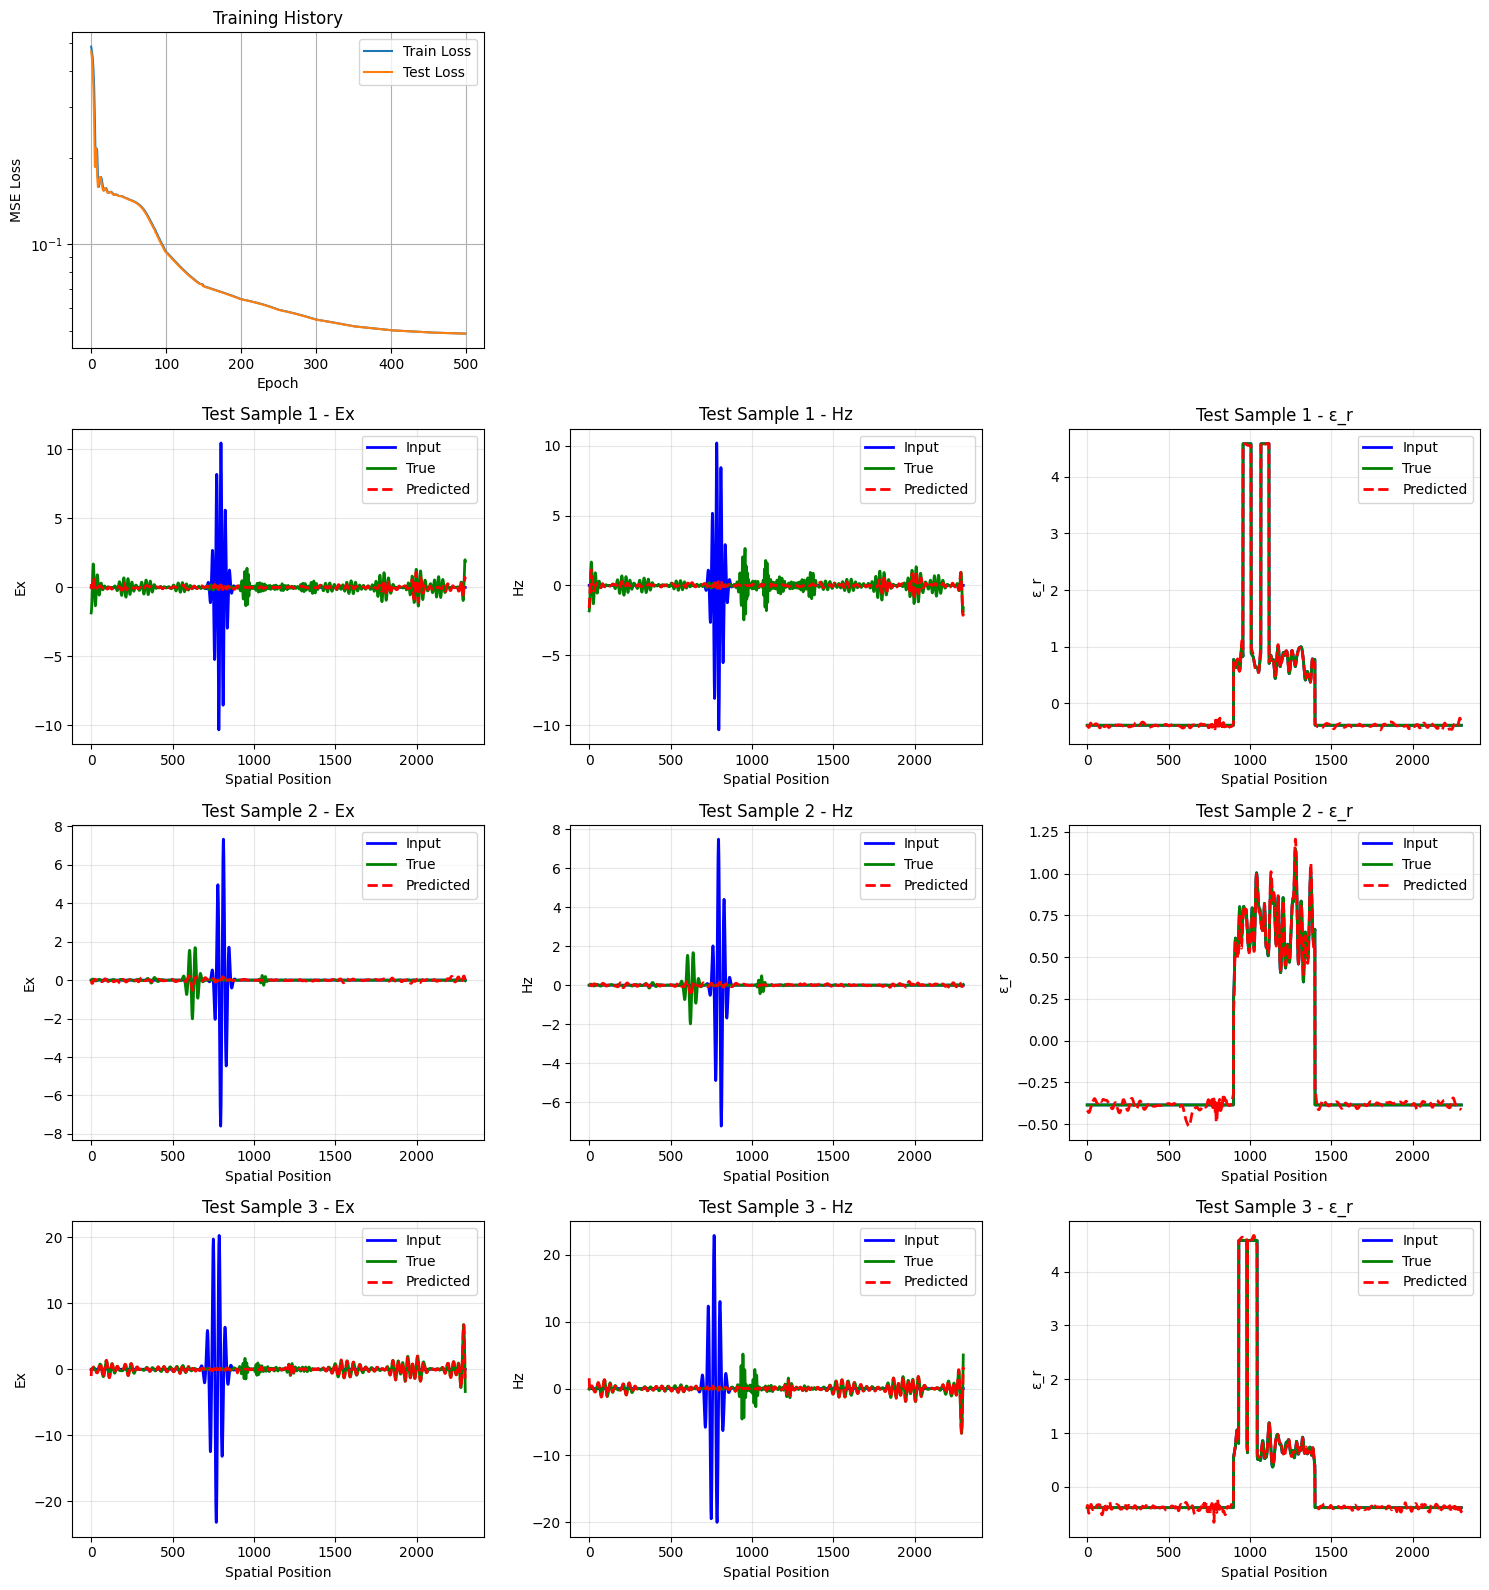


Final Test Metrics:
MSE: 0.048862
Relative L2 Error: 0.323737

Model saved to 'fdtd_fno_model.pth'


wandb: WARNING The get_url method is deprecated and will be removed in a future release. Please use `run.url` instead.


Model logged to wandb as artifact

Final Summary:
Final MSE: 0.04886239767074585
Final Relative L2 Error: 0.32373693585395813
Training Samples: 150
Test Samples: 50
Total Parameters: 3543171
Final Learning Rate: 9.765625e-07

✅ Training complete! View results at: https://wandb.ai/brody-blackwood-belmont-university/fdtd-fno/runs/zt3gz35t


epoch,▁▁▁▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
final_mse,▁
final_relative_l2_error,▁
learning_rate,█████▄▄▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
relative_l2_error,██▇▆▆▆▆▅▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_loss,█▃▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,500
final_mse,0.04886
final_relative_l2_error,0.32374
learning_rate,0.0


In [ ]:


# Create FNO model
model = FNO(
    n_modes=(config.n_modes,),
    hidden_channels=config.hidden_channels,
    in_channels=3,
    out_channels=3,
    n_layers=config.n_layers
).to(device)

n_params = sum(p.numel() for p in model.parameters())
print(f"\nModel parameters: {n_params:,}")
wandb.config.update({"n_parameters": n_params})

# Watch model with wandb
wandb.watch(model, log="all", log_freq=10)

# Training setup
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
#Set loss here
criterion = nn.MSELoss()

# Training loop
train_losses = []
test_losses = []

print("\nStarting training...")
for epoch in range(config.epochs):
    model.train()
    train_loss = 0
    
    # Mini-batch training
    for i in range(0, len(x_train), config.batch_size):
        batch_x = x_train[i:i+config.batch_size]
        batch_y = y_train[i:i+config.batch_size]
        
        optimizer.zero_grad()
        pred = model(batch_x)
        loss = criterion(pred, batch_y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= max(1, (len(x_train) // config.batch_size))
    train_losses.append(train_loss)
    
    # Validation
    model.eval()
    with torch.no_grad():
        test_pred = model(x_test)
        test_loss = criterion(test_pred, y_test).item()
        test_losses.append(test_loss)
        
        # Calculate relative L2 error
        rel_error = torch.mean(torch.norm(test_pred - y_test, dim=(1, 2)) / torch.norm(y_test, dim=(1, 2))).item()
    
    # Log metrics to wandb
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "test_loss": test_loss,
        "relative_l2_error": rel_error,
        "learning_rate": optimizer.param_groups[0]['lr']
    })
    
    scheduler.step()
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}/{config.epochs} | Train Loss: {train_loss:.6f} | Test Loss: {test_loss:.6f} | Rel L2: {rel_error:.6f}")
        
        # Log prediction visualizations every 20 epochs
        # Plot all 3 channels: Ex, Hz, eps
        n_test_samples = min(2, len(x_test))  # Plot up to 2 test samples
        fig, axes = plt.subplots(n_test_samples, 3, figsize=(15, 5*n_test_samples))
        if n_test_samples == 1:
            axes = axes.reshape(1, -1)  # Ensure 2D array
        
        channel_names = ['Ex', 'Hz', 'ε_r']
        x_coords = np.arange(x_test.shape[2])  # Spatial positions
        
        for sample_idx in range(n_test_samples):
            with torch.no_grad():
                pred_sample = model(x_test[sample_idx:sample_idx+1])
            
            for ch_idx, ch_name in enumerate(channel_names):
                axes[sample_idx, ch_idx].plot(x_coords, x_test[sample_idx, ch_idx].cpu().numpy(), 'b-', 
                            label='Input', linewidth=2)
                axes[sample_idx, ch_idx].plot(x_coords, y_test[sample_idx, ch_idx].cpu().numpy(), 'g-', 
                            label='True', linewidth=2)
                axes[sample_idx, ch_idx].plot(x_coords, pred_sample[0, ch_idx].cpu().numpy(), 'r--', 
                            label='Predicted', linewidth=2)
                axes[sample_idx, ch_idx].set_xlabel('Spatial Position')
                axes[sample_idx, ch_idx].set_ylabel(ch_name)
                axes[sample_idx, ch_idx].set_title(f'Sample {sample_idx+1} - {ch_name}')
                axes[sample_idx, ch_idx].legend()
                axes[sample_idx, ch_idx].grid(True, alpha=0.3)
        
        plt.tight_layout()
        fig.savefig('temp_predictions.png', dpi=150, bbox_inches='tight')
        wandb.log({"predictions": wandb.Image('temp_predictions.png')})
        plt.close()

print("\nTraining complete!")

# Final evaluation and comprehensive plots
n_plot_samples = min(3, len(x_test))
fig, axes = plt.subplots(n_plot_samples + 1, 3, figsize=(15, 4*(n_plot_samples+1)))

# Plot training curves in first row
axes[0, 0].plot(train_losses, label='Train Loss')
axes[0, 0].plot(test_losses, label='Test Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('MSE Loss')
axes[0, 0].set_title('Training History')
axes[0, 0].legend()
axes[0, 0].set_yscale('log')
axes[0, 0].grid(True)

# Hide unused subplots in first row
axes[0, 1].axis('off')
axes[0, 2].axis('off')

# Plot predictions for test samples
model.eval()
with torch.no_grad():
    predictions = model(x_test[:n_plot_samples])

channel_names = ['Ex', 'Hz', 'ε_r']
x_coords = np.arange(x_test.shape[2])

for sample_idx in range(n_plot_samples):
    for ch_idx, ch_name in enumerate(channel_names):
        row = sample_idx + 1
        col = ch_idx
        
        axes[row, col].plot(x_coords, x_test[sample_idx, ch_idx].cpu().numpy(), 'b-', 
                            label='Input', linewidth=2)
        axes[row, col].plot(x_coords, y_test[sample_idx, ch_idx].cpu().numpy(), 'g-', 
                            label='True', linewidth=2)
        axes[row, col].plot(x_coords, predictions[sample_idx, ch_idx].cpu().numpy(), 'r--', 
                            label='Predicted', linewidth=2)
        axes[row, col].set_xlabel('Spatial Position')
        axes[row, col].set_ylabel(ch_name)
        axes[row, col].set_title(f'Test Sample {sample_idx+1} - {ch_name}')
        axes[row, col].legend()
        axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('fdtd_fno_results.png', dpi=300, bbox_inches='tight')
print("\nResults saved to 'fdtd_fno_results.png'")

# Log final results to wandb
wandb.log({"final_results": wandb.Image('fdtd_fno_results.png')})
plt.show()
plt.close()

# Calculate and print final error metrics
with torch.no_grad():
    test_pred = model(x_test)
    final_mse = criterion(test_pred, y_test).item()
    final_rel_error = torch.mean(torch.norm(test_pred - y_test, dim=(1, 2)) / torch.norm(y_test, dim=(1, 2))).item()
    
    # Calculate per-sample errors for histogram
    per_sample_errors = torch.norm(test_pred - y_test, dim=(1, 2)) / torch.norm(y_test, dim=(1, 2))
    per_sample_errors = per_sample_errors.cpu().numpy()

print(f"\nFinal Test Metrics:")
print(f"MSE: {final_mse:.6f}")
print(f"Relative L2 Error: {final_rel_error:.6f}")

# Log final metrics
wandb.log({
    "final_mse": final_mse,
    "final_relative_l2_error": final_rel_error
})

# Create error distribution plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.hist(per_sample_errors, bins=30, edgecolor='black', alpha=0.7)
ax.set_xlabel('Relative L2 Error')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Prediction Errors')

ax.grid(True, alpha=0.3)
fig.savefig('error_distribution.png', dpi=150, bbox_inches='tight')
wandb.log({"error_distribution": wandb.Image('error_distribution.png')})
plt.close()


# Save model locally
model_path = 'fdtd_fno_model.pth'
torch.save(model.state_dict(), model_path)
print(f"\nModel saved to '{model_path}'")

# Log model as artifact to wandb
try:
    artifact = wandb.Artifact('fdtd-fno-model', type='model')
    artifact.add_file(model_path)
    wandb.log_artifact(artifact)
    print("Model logged to wandb as artifact")
except Exception as e:
    print(f"Could not save model to wandb: {e}")

# Create a summary table
print("\nFinal Summary:")
print(f"Final MSE: {final_mse}")
print(f"Final Relative L2 Error: {final_rel_error}")
print(f"Training Samples: {n_train}")
print(f"Test Samples: {n_test}")
print(f"Total Parameters: {n_params}")
print(f"Final Learning Rate: {optimizer.param_groups[0]['lr']}")

# Skip wandb table logging
# summary_table = wandb.Table(...)
# wandb.log({"summary": summary_table})

print(f"\n✅ Training complete! View results at: {wandb.run.get_url()}")
wandb.finish()
